In [9]:
import numpy as np

def powers(n,d):
    """ Nonnegative integer tuples of length n which sum to <= d.
    Returns a generator.
    """
    if n == 1:
        for i in range(d+1):
            yield (i,)
    else:
        for i in range(d+1):
            for p in powers(n-1,d):
                t = p + (i,)
                if sum(t) <= d:
                    yield t
                    
                    
def poly(X,d):
    """ Form polynomial "features" for data matrix X.
    Features are monomials of columns of X, with powers <= d.
    
    X is N by n: N examples with n features each.
    
    Returns: Y: N by m matrix, where m is the number of polynomial features, a function of n and d.
    
    >>> import sympy as sp
    >>> x,y,a,b = sp.symbols('x y a b')
    >>> v = np.array([[x,y],[a,b]])
    >>> print poly(v,2)
    
    [[1 x x**2 y x*y y**2]
     [1 a a**2 b a*b b**2]]
     
    >>> print poly(v,3)
    [[1 x x**2 x**3 y x*y x**2*y y**2 x*y**2 y**3]
     [1 a a**2 a**3 b a*b a**2*b b**2 a*b**2 b**3]]
    """
    
    n = X.shape[-1]
    
    result = []
    for p in powers(n,d):
        col = 1
        for i, pi in enumerate(p):
            col *= X[...,i]**pi
        result.append(col)
    return np.vstack(result).T

In [199]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from cvxpy import *

from sklearn.datasets import make_blobs, make_moons

import seaborn as sns
sns.set()
sns.set_style('white')
    

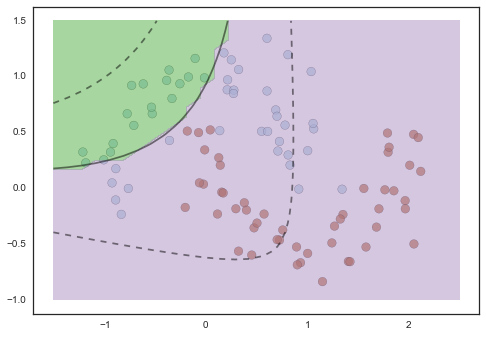

In [101]:
X, y = make_moons(100, noise = .2, random_state=0)
y = 2*y - 1
w = np.random.randn(6)
myplot(X, y, 2, w)

<matplotlib.contour.QuadContourSet instance at 0x10ae775f0>

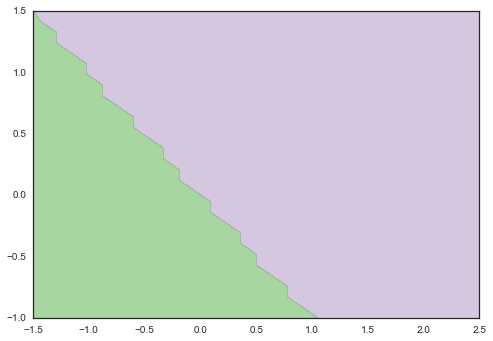

In [42]:
Z = np.sign(X + Y)
#V = [-1,0,+1]
V = 2
plt.contourf(X, Y, Z, V, cmap=plt.cm.Paired, alpha=.5)

In [95]:
poly(X,2).shape

(100, 6)

In [58]:
X2 = poly(X,2)

N,n = X2.shape
N,n

(100, 6)

optimal


<Container object of 3 artists>

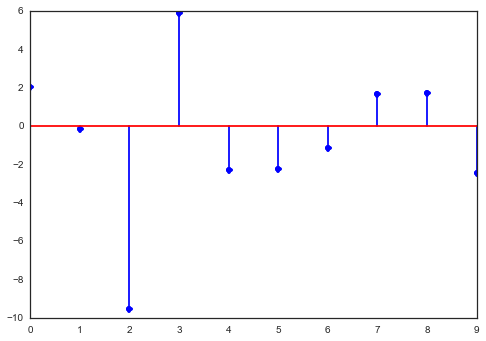

In [59]:
X2 = poly(X,3)

m,n = X2.shape

w = Variable(n)
u = Variable(N)

obj = Minimize(sum_entries(u)+ .2*norm(w[1:],2))
constr = [mul_elemwise(y, X2*w) >= 1 - u, u >= 0]
prob = Problem(obj, constr)
prob.solve()
print prob.status

w = np.array(w.value).flatten()
u = np.array(u.value).flatten()

plt.stem(w)

(array([[-1.5       , -1.5       , -1.5       , ..., -1.5       ,
         -1.5       , -1.5       ],
        [-1.45959596, -1.45959596, -1.45959596, ..., -1.45959596,
         -1.45959596, -1.45959596],
        [-1.41919192, -1.41919192, -1.41919192, ..., -1.41919192,
         -1.41919192, -1.41919192],
        ..., 
        [ 2.41919192,  2.41919192,  2.41919192, ...,  2.41919192,
          2.41919192,  2.41919192],
        [ 2.45959596,  2.45959596,  2.45959596, ...,  2.45959596,
          2.45959596,  2.45959596],
        [ 2.5       ,  2.5       ,  2.5       , ...,  2.5       ,
          2.5       ,  2.5       ]]),
 array([[-1.        , -0.97474747, -0.94949495, ...,  1.44949495,
          1.47474747,  1.5       ],
        [-1.        , -0.97474747, -0.94949495, ...,  1.44949495,
          1.47474747,  1.5       ],
        [-1.        , -0.97474747, -0.94949495, ...,  1.44949495,
          1.47474747,  1.5       ],
        ..., 
        [-1.        , -0.97474747, -0.94949495, ...,

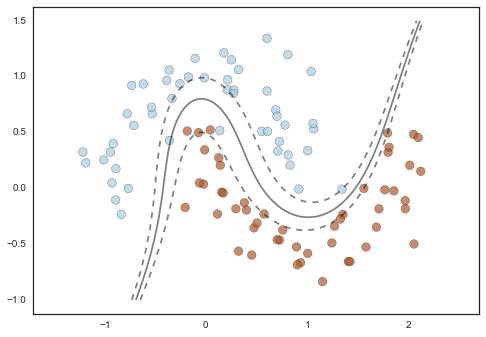

In [62]:
myplot(X, y, 3, w)

# Multiclass

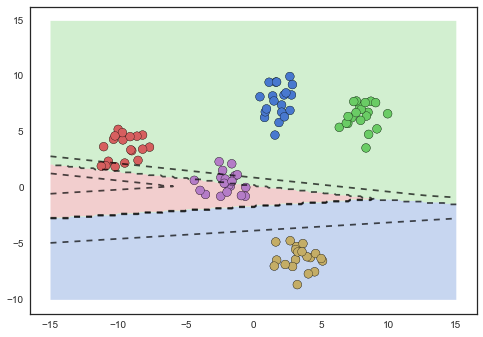

In [578]:
# pretty ones: centers/state:
# 4, 10
# 4, 111

X, y = make_blobs(100, centers=5,random_state=20)
w = np.random.randn(3,3)
myplot(X, y, 1, w)

In [579]:
def hinge(u):
    return pos(1-u)

In [594]:
#X is data; assume first column of 1s
Z = poly(X,2)
m, n = Z.shape
k = max(y) + 1 # number of labels

In [598]:
W = Variable(n, k) # each column of W gives an affine classifier
P = Z*W # examples by predictions matrix

# need to constrain constant values (b) somehow
# have them sum to zero
obj = 0
constr = [sum(W[:,i] for i in range(k)) == 0]
# for each class
for i, label in enumerate(y):
    others = (P[i, j] for j in range(k) if j != label)
    obj += hinge(P[i, label] - max_elemwise(*others)) # but we need to unpack the columns

obj += 1*norm(W[1:,:],'fro')
prob = Problem(Minimize(obj), constr)
prob.solve()

W = np.array(W.value)
print prob.status

optimal


In [645]:
def classify(w):
    """
    Use this function to get smooth contours for the hinge loss's slab width +1 cutoff
    
    if a value is within a slab, add a linear part so that the plotting of the hinge loss
    cutoff is smooth.
    """
    w = w.flatten()
    i = np.argmax(w)
    delta = np.max(w) - max(val for j,val in enumerate(w) if j != i)
    if delta > 2:
        return i + .2
    if 0 < delta <= 2:
        return i + delta/10.0
    else:
        return i

from math import factorial
def getd(X,w):
    _,n = X.shape
    m = w.shape[0]
    for d in range(10):        
        b = factorial(n+d)/(factorial(n)*factorial(d))
        if b == m:
            return d
    
    raise ValueError("w doesn't have the right length to be a polynomial weight vector for X")

def myplot(X, y, w=None):
    """
    w gives weights of polynomial terms
    
    
    todo: with no w, don't plot contour
    todo: toggle dashed lines
    """
    n,k = w.shape
    d = getd(X,w)
    
    line_alpha=1
    
    yc = np.array(y, dtype=float)
    Xs = X
    
    c = sns.color_palette("muted")
    clabels = [list(c)[i] for i in y]

    # todo: way to get the xlim and ylim of the scatter without making the scatter?
    # or maybe we should just nest in a function to return x and y lim?
    plt.scatter(Xs[:,0], Xs[:, 1], c=clabels, s=75, alpha=.7)

    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 200)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 200)
    Y, X = np.meshgrid(y, x)

    # todo: don't do nested loops, use numpy operations for speed
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            v = np.array([xi, yj])
            v = poly(v,d)
            #P[i, j] = np.argmax(v.dot(w))
            P[i, j] = classify(v.dot(w))

    levels= np.arange(k)+.1
    linestyles=['--']*k

    plt.contour(X, Y, P, colors='k',
               levels=levels, alpha=.7,
               linestyles=linestyles,antialiased=True)
    
    P = P.astype(int)
    
    ## contourf colors the N-1 regions between the N values in V
    V = np.arange(k+1)-.5
    
    plt.contourf(X, Y, P, V, colors=c, alpha=.3,antialiased=True)
    
    # todo: get rid of these weird Xs extra variables
    plt.scatter(Xs[:,0], Xs[:, 1], c=clabels, s=75, alpha=1)

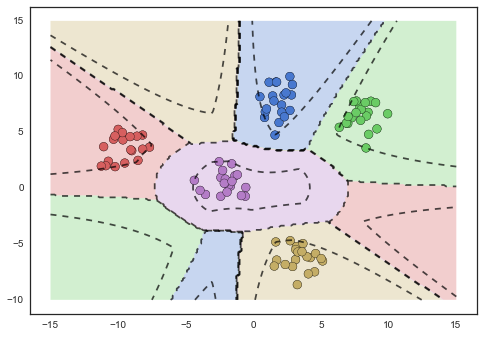

In [646]:
myplot(X, y, W)

In [511]:
# compare the predicted label with the given label
np.argmax(Z.dot(W),1) == y

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)